In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
from sklearn.model_selection import ShuffleSplit

import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout 
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam # - Works

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers


pathDefectTile = "C:/Users/schof/LeedsUni/personalproject/DefectTiles/"
pathDefectTileStrict = "C:/Users/schof/LeedsUni/personalproject/DefectTilesStrict/"
pathGoodTile = "C:/Users/schof/LeedsUni/personalproject/GoodTiles/"

img_height = 64
img_width = 64

class_names = ["normal", "defect"]

In [20]:
# importing test tiles. Do not need to be partitioned as test train sets as its rule based

goodNamesAll = os.listdir(pathGoodTile)
goodNames = []

# only importing a fraction of good tiles to not add bias to system
# indexes = np.random.randint(0, len(goodNamesAll)-1, size=11000)
indexes = np.random.randint(0, len(goodNamesAll)-1, size=1000)


for i in indexes:
    goodNames.append(goodNamesAll[i])
    
all_features = []
all_lables = []


for name in goodNames:
#     img = cv2.imread(pathGoodTile+name)[...,::-1]
    img = cv2.imread(pathGoodTile+name)
    cv2.resize(img, (img_size, img_size))
    all_features.append(img)
#     all_lables.append("normal")
    all_lables.append(0)

    


In [21]:
defectNames = os.listdir(pathDefectTileStrict)

print(len(defectNames))

for name in defectNames:
#     img = cv2.imread(pathDefectTileStrict+name)[...,::-1]
    img = cv2.imread(pathDefectTileStrict+name)
    cv2.resize(img, (img_size, img_size))
    all_features.append(img)
#     all_lables.append("defect")
    all_lables.append(1)



1019


In [22]:
test_size = int(0.1*len(all_features)) # 10%
indexesTest = np.random.randint(0, len(all_features), size=test_size)

test_features = []
test_lables = []
train_features = []
train_lables = []

print(len(all_features))

for i in range(0, len(all_features)):
    if i in indexesTest:
        test_features.append(all_features[i])
        test_lables.append(all_lables[i])
    else:
        train_features.append(all_features[i])
        train_lables.append(all_lables[i])
    
# now we shuffell the test and training sets, to reduce bias and converge faster

print("counts:")

print(test_lables.count(1))
print(test_lables.count(0))
print(train_lables.count(1))
print(train_lables.count(0))


def shuffle(features, lables):
    size_s = int(0.8*(len(features)))
    shuffle_1 = np.random.randint(0, len(features), size=size_s)
    shuffle_2 = np.random.randint(0, len(features), size=size_s)
    
    for i in range(0,len(shuffle_1)):
        temp = features[shuffle_1[i]]
        features[shuffle_1[i]] = features[shuffle_2[i]]
        features[shuffle_2[i]] = temp
    
        temp = lables[shuffle_1[i]]
        lables[shuffle_1[i]] = lables[shuffle_2[i]]
        lables[shuffle_2[i]] = temp
        
    return features, lables


test_features, test_lables =  shuffle(test_features, test_lables)

train_features, train_lables =  shuffle(train_features, train_lables)


print("--------------\ncounts after shuffle:")

print(test_lables.count(1))
print(test_lables.count(0))
print(train_lables.count(1))
print(train_lables.count(0))
    
    
    


2019
counts:
101
90
918
910
--------------
counts after shuffle:
101
90
918
910


80
89
838
821


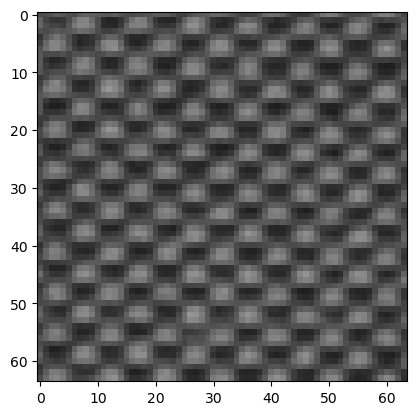

In [23]:
# finally i need to split the training data into training and validation sets

test_size = int(0.1*len(train_features)) # 10%
indexesTest = np.random.randint(0, len(train_features), size=test_size)

p_x_val = []
p_y_val = []
p_x_train = []
p_y_train = []

for i in range(0, len(train_features)):
    if i in indexesTest:
        p_x_val.append(train_features[i])
        p_y_val.append(train_lables[i])
    else:
        p_x_train.append(train_features[i])
        p_y_train.append(train_lables[i])
        
print(p_y_val.count(1))
print(p_y_val.count(0))
print(p_y_train.count(1))
print(p_y_train.count(0))

plt.imshow(p_x_train[100])
plt.show()

In [24]:
# now we need to reshape and norlalise all the date so it can be used in a CNN
N = len(p_x_train)
H = img_size
W = img_size
x_train = np.empty((N, H, W, 3), dtype=np.float32) 
N = len(p_x_val)
x_val = np.empty((N, H, W, 3), dtype=np.float32) 
N = len(test_features)
x_test = np.empty((N, H, W, 3), dtype=np.float32) 


for i in range(0, len(p_x_train)):
    x_train[i] = p_x_train[i]
    
for i in range(0, len(p_x_val)):
    x_val[i] = p_x_val[i]
    
for i in range(0, len(test_features)):
    x_test[i] = test_features[i]
    
    
# x_train = np.array(x_train) / 255
# x_val = np.array(x_val) / 255
# x_test = np.array(x_val) / 255


x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(p_y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(p_y_val)

x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(test_lables)

uniqueV, countsV = np.unique(y_val, return_counts=True)
uniqueT, countsT = np.unique(y_train, return_counts=True)
print(countsV)
print(countsT)

print(x_train[0])
print(y_train)


[89 80]
[821 838]
[[[215. 215. 215.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [147. 147. 147.]
  [123. 123. 123.]
  [118. 118. 118.]]

 [[205. 205. 205.]
  [239. 239. 239.]
  [255. 255. 255.]
  ...
  [150. 150. 150.]
  [133. 133. 133.]
  [111. 111. 111.]]

 [[189. 189. 189.]
  [212. 212. 212.]
  [255. 255. 255.]
  ...
  [153. 153. 153.]
  [136. 136. 136.]
  [117. 117. 117.]]

 ...

 [[144. 144. 144.]
  [122. 122. 122.]
  [116. 116. 116.]
  ...
  [132. 132. 132.]
  [140. 140. 140.]
  [121. 121. 121.]]

 [[154. 154. 154.]
  [126. 126. 126.]
  [108. 108. 108.]
  ...
  [130. 130. 130.]
  [132. 132. 132.]
  [125. 125. 125.]]

 [[152. 152. 152.]
  [133. 133. 133.]
  [116. 116. 116.]
  ...
  [129. 129. 129.]
  [133. 133. 133.]
  [134. 134. 134.]]]
[1 0 1 ... 1 0 0]


In [25]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [27]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        1

In [29]:
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

epochs=10
history = model.fit(
  x_train, y_train,
  validation_data=x_val,y_val
  epochs=epochs
)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3982859383.py, line 11)